# Social Network Analysis on Facebook dataset

Let us load the modules that we use for this analysis

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from itertools import groupby
import random
from tqdm import tqdm

Reading the node and edge files

In [2]:
edges = pd.read_csv('data/socfb-nips-ego.csv')

In [3]:
edges.shape

(2981, 2)

In [4]:
edges.head()

,From,To
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6


In [5]:
edges.dtypes

From    int64
To      int64
dtype: object

Create a grpah object from the edge list

In [7]:
snfb = nx.from_pandas_edgelist(df=edges, source='From', target='To')

In [8]:
# Quick Snapshot of the network
print(nx.info(snfb))

Name: 
Type: Graph
Number of nodes: 2888
Number of edges: 2981
Average degree:   2.0644


Visualizing Graph might take some time

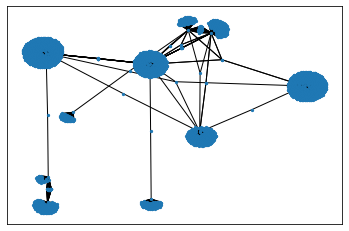

In [11]:
nx.draw_networkx(snfb, pos=nx.spring_layout(snfb), with_labels=False, node_size=5)

As we can see, there are lot small subgraphs in this network. Let us just focus on teh largest connected component

In [12]:
[len(c) for c in sorted(nx.connected_components(snfb), key=len, reverse=True)]

[2888]

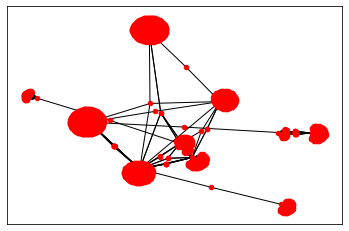

In [13]:
nx.draw_networkx(snfb, pos=nx.spring_layout(snfb), with_labels=False, node_size=20, node_color='r')

Extract local node features for all the nodes present in largest connected graph

In [15]:
g_features = pd.DataFrame({'Degree':nx.degree_centrality(snfb),
                           'Closeness':nx.closeness_centrality(snfb),
                           'Betweenness':nx.betweenness_centrality(snfb),
                           'Eigenvector':nx.eigenvector_centrality_numpy(snfb),
                           'Katz':nx.katz_centrality_numpy(snfb),
                           'PageRank':nx.pagerank(snfb),
                           'GlobalReaching':nx.global_reaching_centrality(snfb)
})

In [16]:
g_features.head()

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,GlobalReaching
1,0.099411,0.345005,0.186097,0.008460,-0.029202,0.045075,0.235121
2,0.000346,0.256531,0.000000,0.000304,-0.000943,0.000186,0.235121
3,0.000346,0.256531,0.000000,0.000304,-0.000943,0.000186,0.235121
4,0.000346,0.256531,0.000000,0.000304,-0.000943,0.000186,0.235121
5,0.000346,0.256531,0.000000,0.000304,-0.000943,0.000186,0.235121


Let us look at the correlations between these local graph metrics

In [17]:
corr = g_features.corr()
corr.style.background_gradient(cmap='RdYlGn').set_precision(2)

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,GlobalReaching
Degree,1.00,0.12,0.93,0.52,-0.01,1.00,-0.00
Closeness,0.12,1.00,0.14,0.38,-0.27,0.12,-0.00
Betweenness,0.93,0.14,1.00,0.50,-0.01,0.93,-0.00
Eigenvector,0.52,0.38,0.50,1.00,-0.08,0.52,0.00
Katz,-0.01,-0.27,-0.01,-0.08,1.00,-0.00,0.00
PageRank,1.00,0.12,0.93,0.52,-0.00,1.00,-0.00
GlobalReaching,-0.00,-0.00,-0.00,0.00,0.00,-0.00,1.00


We will apply an anomaly detection technique called IsolationForest to identify anomalous communication behavior based on local graph metrics

In [18]:
from sklearn.ensemble import IsolationForest
isof = IsolationForest(n_estimators=1000, max_samples='auto', contamination=0.1, 
                      max_features=1.0, bootstrap=False, n_jobs=-1,
                      random_state=2020, verbose=1, behaviour='new')
isof.fit(g_features)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.0s remaining:    2.2s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    1.1s finished


IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples='auto', n_estimators=1000,
                n_jobs=-1, random_state=2020, verbose=1, warm_start=False)

In [19]:
anomaly_score = isof.decision_function(g_features)
anomaly_score_new = np.interp(anomaly_score, (np.min(anomaly_score), np.max(anomaly_score)), (0,1))

In [20]:
g_features['anomaly_score_new'] = anomaly_score_new

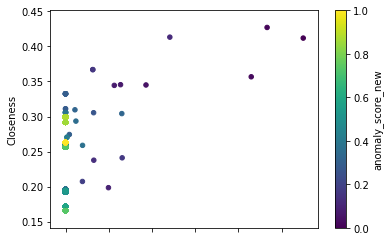

In [21]:
g_features.plot.scatter(x='Betweenness',
                       y='Closeness',
                       c='anomaly_score_new',
                       colormap='viridis')

From the above scatter plot, we cann see all teh darker points are anomalies based on Betweenness Centrality and Closeness Centrality

In [22]:
g_features = g_features.sort_values(by='anomaly_score_new', ascending=True)

In [23]:
import gc
gc.collect()

75

In [26]:
color_map = []
for node in snfb:
    if node in g_features.index[-5:]:
        color_map.append('red')
    else: color_map.append('green')

In [27]:
size_map = []
for node in snfb:
    if node in g_features.index[-5:]:
        size_map.append(200)
    else: size_map.append(100) 
    

Top 10 anomalies absed on all the local metrics that we calculated

In [28]:
g_features.head(10)

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,GlobalReaching,anomaly_score_new
603,0.266366,0.411899,0.549707,0.702482,-0.022221,0.121193,0.235121,0.000000
288,0.166609,0.427071,0.466130,0.092219,-0.022392,0.074106,0.235121,0.013994
1525,0.245930,0.356684,0.429445,0.016210,-0.022881,0.112474,0.235121,0.023546
1,0.099411,0.345005,0.186097,0.008460,-0.029202,0.045075,0.235121,0.048307
710,0.076550,0.345418,0.127247,0.006952,-0.009795,0.031053,0.235121,0.070243
714,0.048147,0.344429,0.112768,0.005729,-0.053892,0.018858,0.235121,0.076022
2687,0.058885,0.198487,0.099288,0.000081,-0.048247,0.024981,0.235121,0.093893
247,0.001386,0.413255,0.241242,0.029471,-0.007693,0.000587,0.235121,0.120956
2232,0.033599,0.237691,0.065410,0.000136,0.697590,0.015509,0.235121,0.135560
716,0.001386,0.366929,0.063049,0.004356,-0.008919,0.000554,0.235121,0.156625


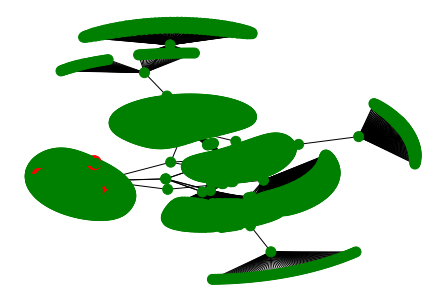

In [29]:
pos=nx.kamada_kawai_layout(snfb)
nx.draw(snfb, node_color = color_map, node_size=size_map, pos = pos, with_labels = False)

We can not really visualize those nodes that are anomalous

These are top 10 anomalous communicators based on our analysis

Let us detect communities based on the similar patterns in emails

In [34]:
from community import community_louvain
parts = community_louvain.best_partition(snfb)
values = [parts.get(node) for node in snfb.nodes()]

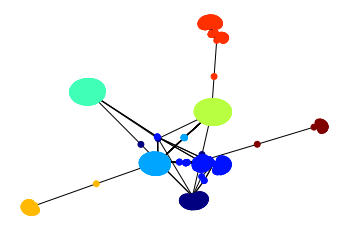

In [35]:
plt.axis("off")
spring_pos=nx.spring_layout(snfb)
nx.draw_networkx(snfb, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)

In [37]:
same_neighbors = lambda u, v: (u not in snfb[v] and v not in snfb[u] and snfb[u] == snfb[v])
qsnfb = nx.quotient_graph(snfb, same_neighbors)

In [77]:
print(nx.info(qsnfb))

Name: 
Type: Graph
Number of nodes: 35
Number of edges: 52
Average degree:   2.9714


In [38]:
from community import community_louvain
parts = community_louvain.best_partition(qsnfb)
values = [parts.get(node) for node in qsnfb.nodes()]

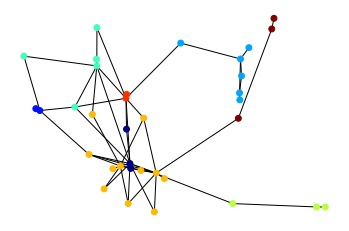

In [57]:
plt.axis("off")
spring_pos=nx.spring_layout(qsnfb)
nx.draw_networkx(qsnfb, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)

In [72]:
from pyvis.network import Network
net = Network("1000px", "1000px", notebook=True)

In [78]:
net.from_nx(snfb)
# net.show_buttons(filter_=['physics'])

In [79]:
net.show('snfb.html')